# Comprehensive VAE Implementation: Autoencoders, VAEs, f-VAEs, and β-VAEs

This notebook implements a complete exploration of Variational Autoencoders and related architectures for image compression and generation on MNIST datasets.

## Project Outline:
1. **Simple Autoencoder** - Compression analysis with different latent sizes
2. **Variational Autoencoder (VAE)** - Implementation for MNIST Digits and Fashion-MNIST
3. **f-VAE** - VAE combined with RealNVP normalizing flows
4. **β-VAE** - Exploring disentanglement with different β values

## Requirements:
- PyTorch/TensorFlow
- NumPy, Matplotlib
- MNIST and Fashion-MNIST datasets

## 1. Import Required Libraries and Setup

In [1]:
# Import all required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import os
import random
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    device = torch.device('mps')

print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Using device: mps
PyTorch version: 2.9.0


## 2. Load and Preprocess MNIST and Fashion-MNIST Datasets

In [2]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten to 784 dimensions
])

# Load MNIST Digits dataset
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, 
                                        download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, 
                                       download=True, transform=transform)

# Load Fashion-MNIST dataset
fashion_train = torchvision.datasets.FashionMNIST(root='./data', train=True, 
                                                 download=True, transform=transform)
fashion_test = torchvision.datasets.FashionMNIST(root='./data', train=False, 
                                                download=True, transform=transform)

# Create data loaders
batch_size = 128
mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
fashion_train_loader = DataLoader(fashion_train, batch_size=batch_size, shuffle=True)
fashion_test_loader = DataLoader(fashion_test, batch_size=batch_size, shuffle=False)

# Print dataset information
print("Dataset Information:")
print(f"MNIST - Train: {len(mnist_train)} samples, Test: {len(mnist_test)} samples")
print(f"Fashion-MNIST - Train: {len(fashion_train)} samples, Test: {len(fashion_test)} samples")
print(f"Batch size: {batch_size}")
print(f"Input dimensions: 784 (28x28 flattened)")

# Fashion-MNIST class names
fashion_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

100%|██████████| 9.91M/9.91M [00:04<00:00, 2.39MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 215kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.14MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.41MB/s]
100%|██████████| 26.4M/26.4M [00:07<00:00, 3.77MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 562kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.54MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 993kB/s]

Dataset Information:
MNIST - Train: 60000 samples, Test: 10000 samples
Fashion-MNIST - Train: 60000 samples, Test: 10000 samples
Batch size: 128
Input dimensions: 784 (28x28 flattened)


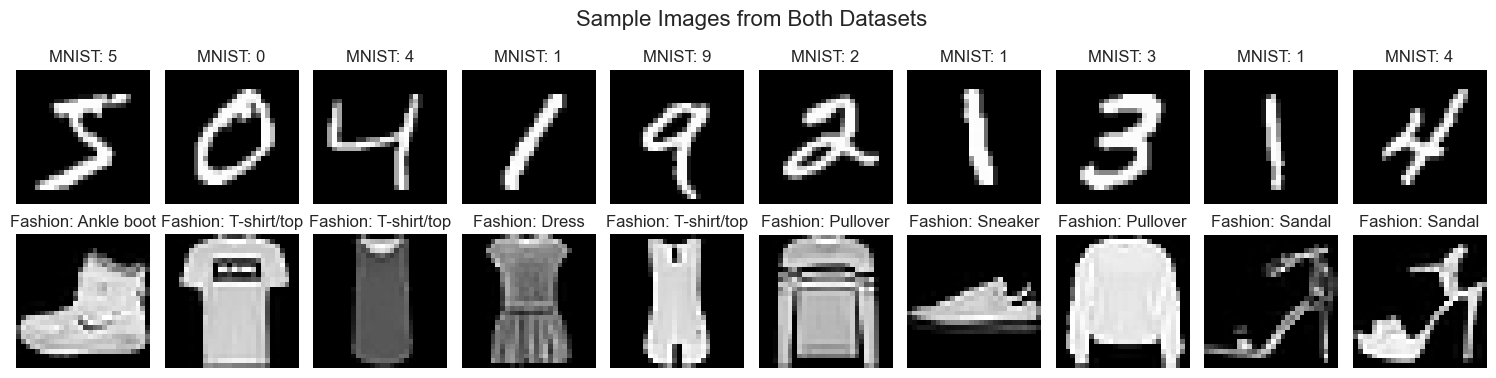

In [3]:
# Visualize sample images from both datasets
def visualize_samples(dataset, dataset_name, n_samples=10):
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 4))
    
    for i in range(n_samples):
        # MNIST
        img, label = mnist_train[i]
        axes[0, i].imshow(img.view(28, 28), cmap='gray')
        axes[0, i].set_title(f'MNIST: {label}')
        axes[0, i].axis('off')
        
        # Fashion-MNIST
        img, label = fashion_train[i]
        axes[1, i].imshow(img.view(28, 28), cmap='gray')
        axes[1, i].set_title(f'Fashion: {fashion_classes[label]}')
        axes[1, i].axis('off')
    
    plt.suptitle('Sample Images from Both Datasets', fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_samples(mnist_train, "MNIST")

## 3. Implement Simple Autoencoder Architecture

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, latent_dim=64):
        super(Autoencoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # Output values between 0 and 1
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z

# Training function for autoencoder
def train_autoencoder(model, train_loader, epochs=20, lr=1e-3):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            
            # Forward pass
            recon_data, _ = model(data)
            loss = criterion(recon_data, data)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}')
    
    return train_losses

# Test function for autoencoder
def test_autoencoder(model, test_loader):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0.0
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_data, _ = model(data)
            loss = criterion(recon_data, data)
            total_loss += loss.item()
    
    return total_loss / len(test_loader)

print("✅ Autoencoder architecture implemented!")

✅ Autoencoder architecture implemented!


## 4. Train Autoencoder with Different Latent Sizes

In [5]:
# Different latent dimensions to experiment with
latent_dims = [2, 8, 16, 32, 64, 128]
autoencoder_results = {}

print("Training autoencoders with different latent dimensions...")
print("="*60)

for latent_dim in latent_dims:
    print(f"\nTraining autoencoder with latent dim = {latent_dim}")
    print("-" * 40)
    
    # Create and train model
    model = Autoencoder(input_dim=784, latent_dim=latent_dim)
    train_losses = train_autoencoder(model, mnist_train_loader, epochs=20)
    
    # Test the model
    test_loss = test_autoencoder(model, mnist_test_loader)
    
    # Store results
    autoencoder_results[latent_dim] = {
        'model': model,
        'train_losses': train_losses,
        'test_loss': test_loss
    }
    
    print(f"Final test loss: {test_loss:.6f}")

print("\n✅ All autoencoder models trained!")

Training autoencoders with different latent dimensions...

Training autoencoder with latent dim = 2
----------------------------------------
Epoch [5/20], Loss: 0.039284
Epoch [10/20], Loss: 0.036954
Epoch [15/20], Loss: 0.035789
Epoch [20/20], Loss: 0.034930
Final test loss: 0.035666

Training autoencoder with latent dim = 8
----------------------------------------
Epoch [5/20], Loss: 0.017699
Epoch [10/20], Loss: 0.015261
Epoch [15/20], Loss: 0.014050
Epoch [20/20], Loss: 0.013335
Final test loss: 0.014338

Training autoencoder with latent dim = 16
----------------------------------------
Epoch [5/20], Loss: 0.011665
Epoch [10/20], Loss: 0.009293
Epoch [15/20], Loss: 0.008327
Epoch [20/20], Loss: 0.007750
Final test loss: 0.008259

Training autoencoder with latent dim = 32
----------------------------------------
Epoch [5/20], Loss: 0.009684
Epoch [10/20], Loss: 0.006540
Epoch [15/20], Loss: 0.005436
Epoch [20/20], Loss: 0.004810
Final test loss: 0.005127

Training autoencoder with l

## 5. Analyze Reconstruction Quality vs Latent Size

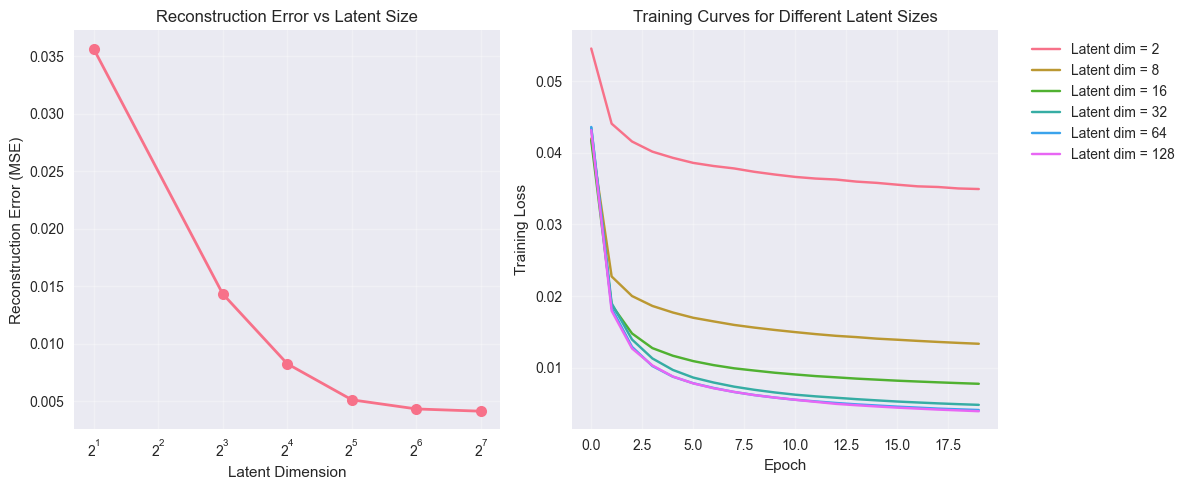

Reconstruction Error Analysis:
Latent dim   2: MSE = 0.035666, Compression = 392.0x
Latent dim   8: MSE = 0.014338, Compression = 98.0x
Latent dim  16: MSE = 0.008259, Compression = 49.0x
Latent dim  32: MSE = 0.005127, Compression = 24.5x
Latent dim  64: MSE = 0.004334, Compression = 12.2x
Latent dim 128: MSE = 0.004138, Compression = 6.1x


In [6]:
# Plot reconstruction error vs latent size
test_losses = [autoencoder_results[dim]['test_loss'] for dim in latent_dims]

plt.figure(figsize=(12, 5))

# Plot 1: Reconstruction error vs latent size
plt.subplot(1, 2, 1)
plt.plot(latent_dims, test_losses, 'o-', linewidth=2, markersize=8)
plt.xlabel('Latent Dimension')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Reconstruction Error vs Latent Size')
plt.grid(True, alpha=0.3)
plt.xscale('log', base=2)

# Plot 2: Training curves for different latent sizes
plt.subplot(1, 2, 2)
for latent_dim in latent_dims:
    train_losses = autoencoder_results[latent_dim]['train_losses']
    plt.plot(train_losses, label=f'Latent dim = {latent_dim}')

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Curves for Different Latent Sizes')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print numerical results
print("Reconstruction Error Analysis:")
print("="*40)
for latent_dim in latent_dims:
    test_loss = autoencoder_results[latent_dim]['test_loss']
    compression_ratio = 784 / latent_dim
    print(f"Latent dim {latent_dim:3d}: MSE = {test_loss:.6f}, Compression = {compression_ratio:.1f}x")

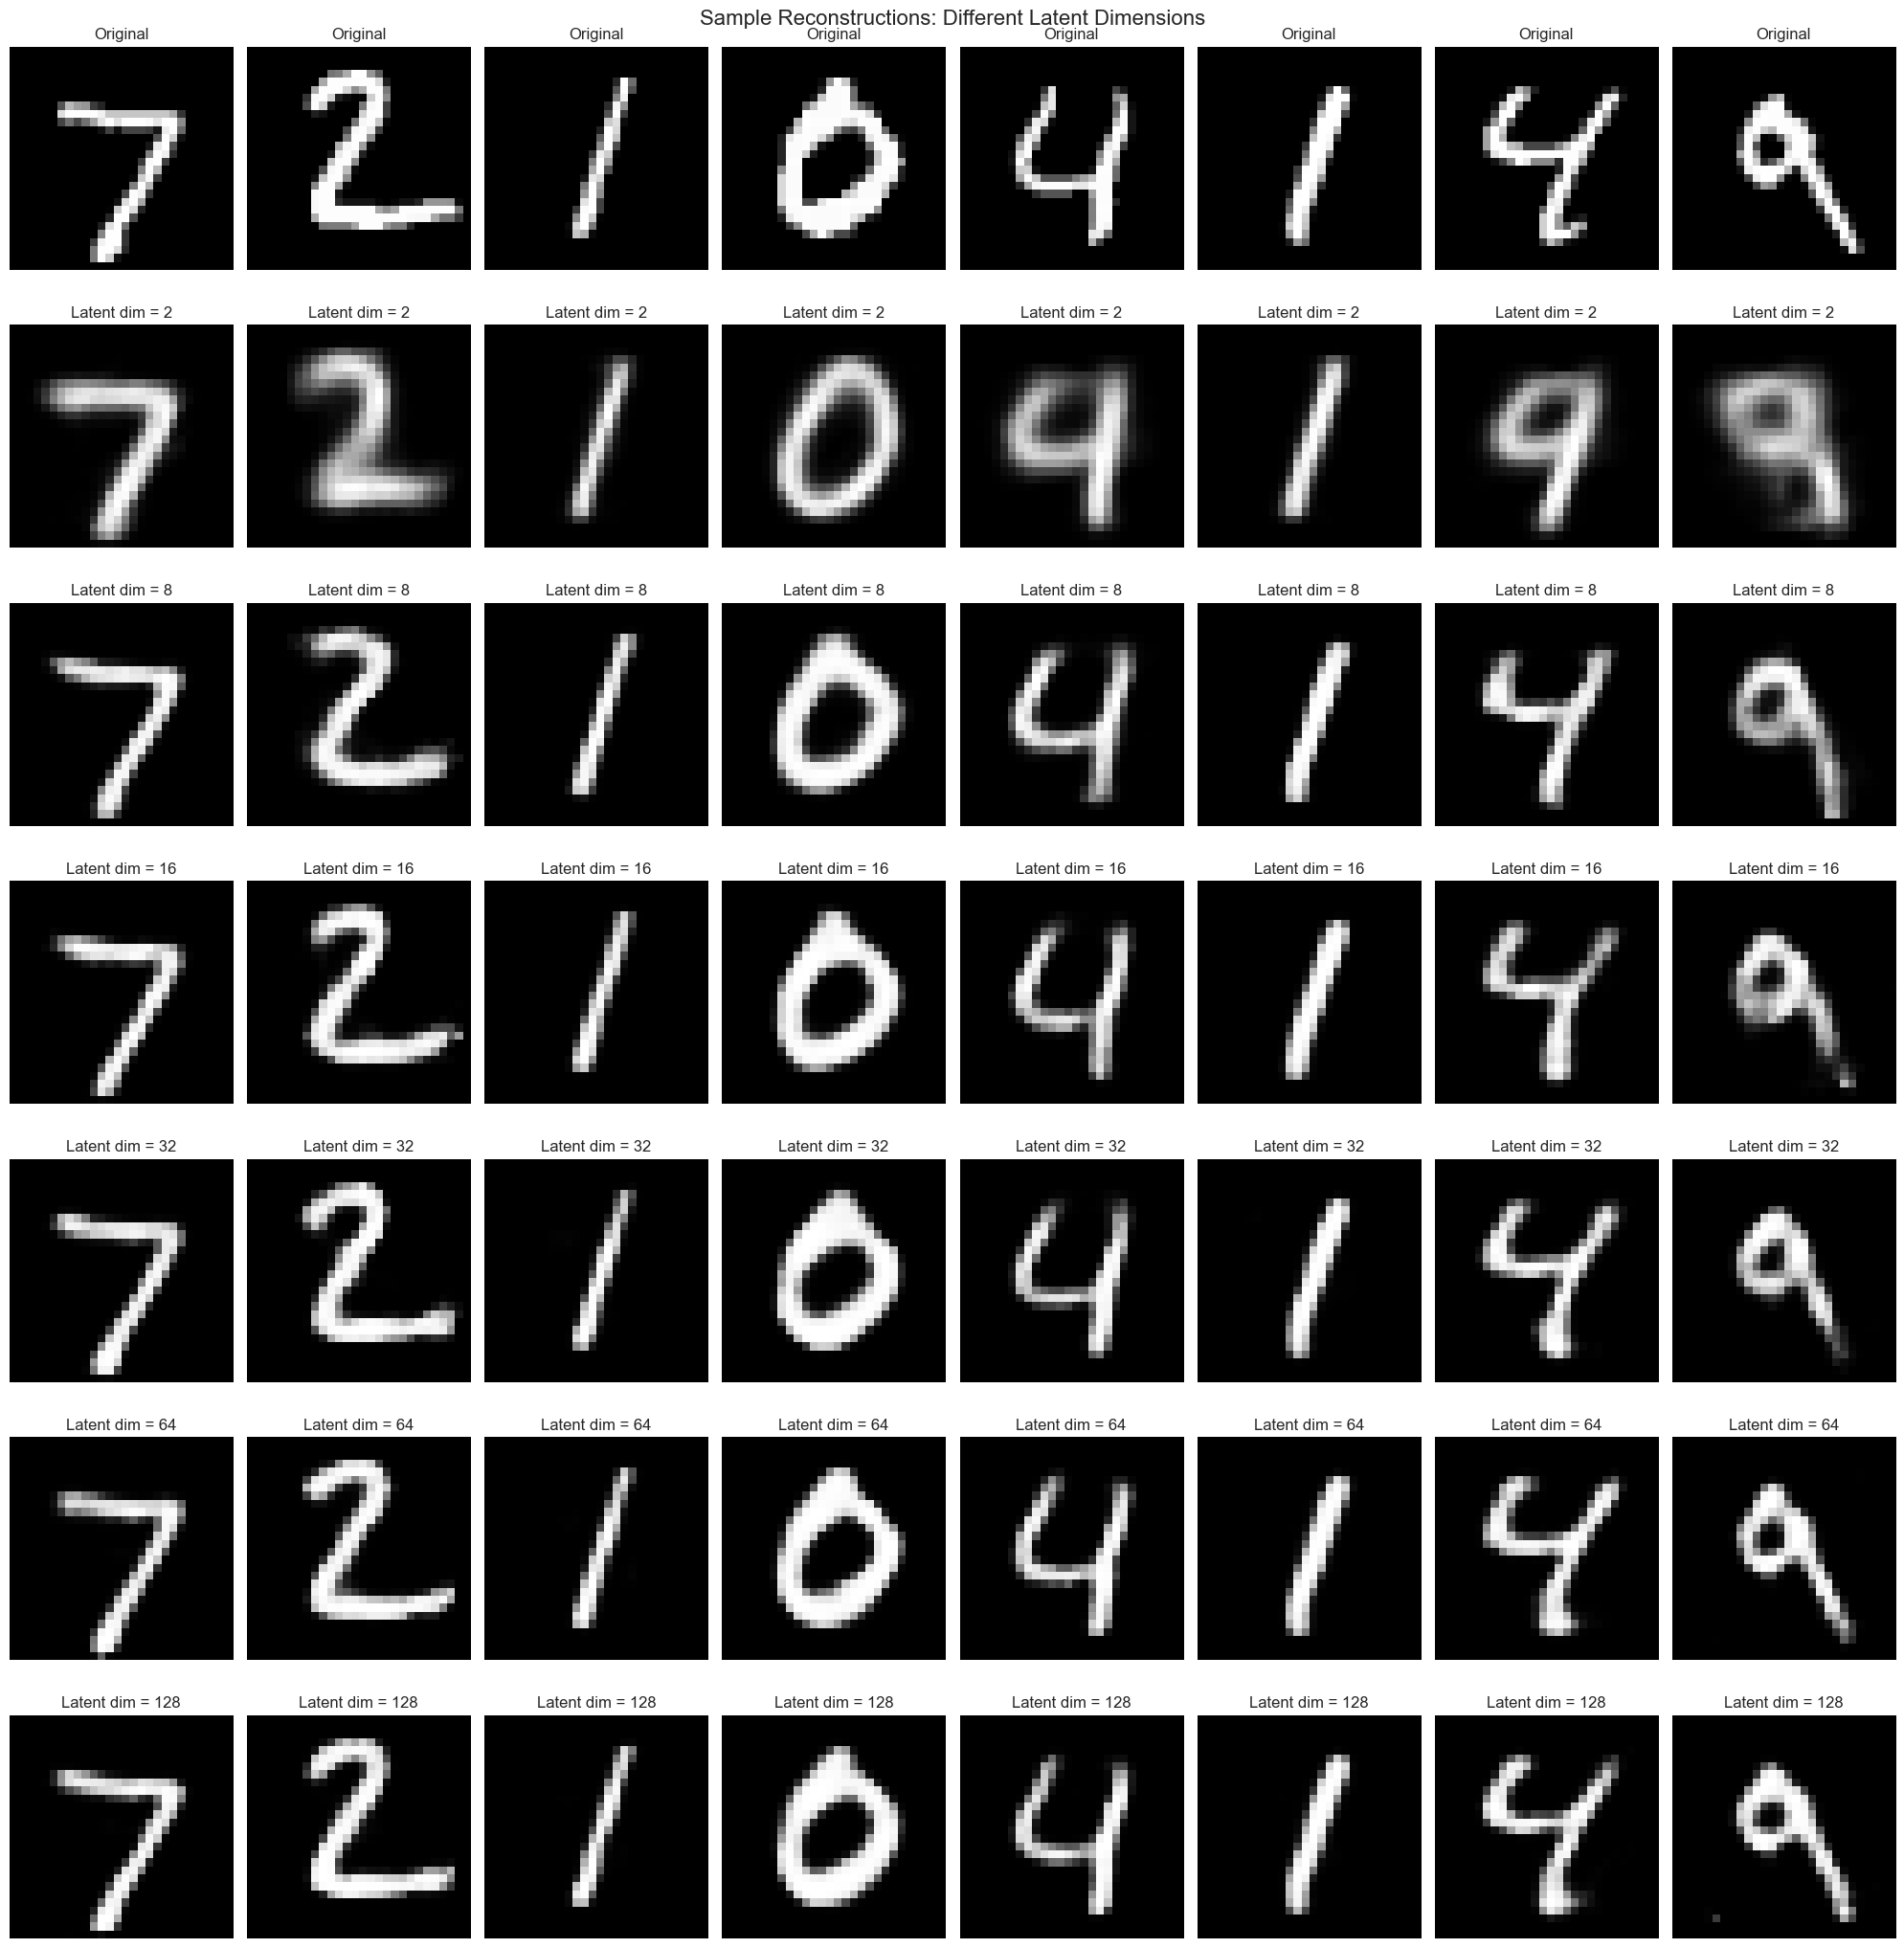

In [7]:
# Visualize sample reconstructions for different latent sizes
def visualize_reconstructions(models_dict, test_loader, n_samples=8):
    # Get sample data
    data_iter = iter(test_loader)
    sample_data, _ = next(data_iter)
    sample_data = sample_data[:n_samples].to(device)
    
    n_models = len(models_dict)
    fig, axes = plt.subplots(n_models + 1, n_samples, figsize=(20, 3 * (n_models + 1)))
    
    # Original images (top row)
    for i in range(n_samples):
        axes[0, i].imshow(sample_data[i].cpu().view(28, 28), cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
    
    # Reconstructions for each model
    for row_idx, (latent_dim, result_dict) in enumerate(models_dict.items(), 1):
        model = result_dict['model']
        model.eval()
        
        with torch.no_grad():
            recon_data, _ = model(sample_data)
        
        for i in range(n_samples):
            axes[row_idx, i].imshow(recon_data[i].cpu().view(28, 28), cmap='gray')
            axes[row_idx, i].set_title(f'Latent dim = {latent_dim}')
            axes[row_idx, i].axis('off')
    
    plt.suptitle('Sample Reconstructions: Different Latent Dimensions', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize reconstructions
visualize_reconstructions(autoencoder_results, mnist_test_loader)

## 6. Implement VAE Architecture

In [8]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, latent_dim=20):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        
        # Latent space
        self.fc_mu = nn.Linear(256, latent_dim)      # Mean
        self.fc_logvar = nn.Linear(256, latent_dim)  # Log variance
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick: sample from N(mu, var) using N(0,1)"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar, z

# VAE Loss function
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE loss = Reconstruction loss + KL divergence
    """
    # Reconstruction loss (binary cross-entropy)
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + beta * kl_loss, recon_loss, kl_loss

# Training function for VAE
def train_vae(model, train_loader, epochs=50, lr=1e-3, beta=1.0):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    recon_losses = []
    kl_losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        epoch_recon = 0.0
        epoch_kl = 0.0
        
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            
            # Forward pass
            recon_data, mu, logvar, _ = model(data)
            loss, recon_loss, kl_loss = vae_loss(recon_data, data, mu, logvar, beta)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_recon += recon_loss.item()
            epoch_kl += kl_loss.item()
        
        # Average losses
        avg_loss = epoch_loss / len(train_loader.dataset)
        avg_recon = epoch_recon / len(train_loader.dataset)
        avg_kl = epoch_kl / len(train_loader.dataset)
        
        train_losses.append(avg_loss)
        recon_losses.append(avg_recon)
        kl_losses.append(avg_kl)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Total Loss: {avg_loss:.4f}, '
                  f'Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}')
    
    return train_losses, recon_losses, kl_losses

print("✅ VAE architecture implemented!")

✅ VAE architecture implemented!


## 7. Train VAE on MNIST Digits

Training VAE on MNIST Digits...
Epoch [10/50], Total Loss: 103.9439, Recon: 85.0550, KL: 18.8889
Epoch [20/50], Total Loss: 100.2014, Recon: 80.7250, KL: 19.4764
Epoch [30/50], Total Loss: 98.6389, Recon: 78.9324, KL: 19.7065
Epoch [40/50], Total Loss: 97.7134, Recon: 77.8932, KL: 19.8203
Epoch [50/50], Total Loss: 97.1363, Recon: 77.2202, KL: 19.9161
✅ MNIST VAE training completed!


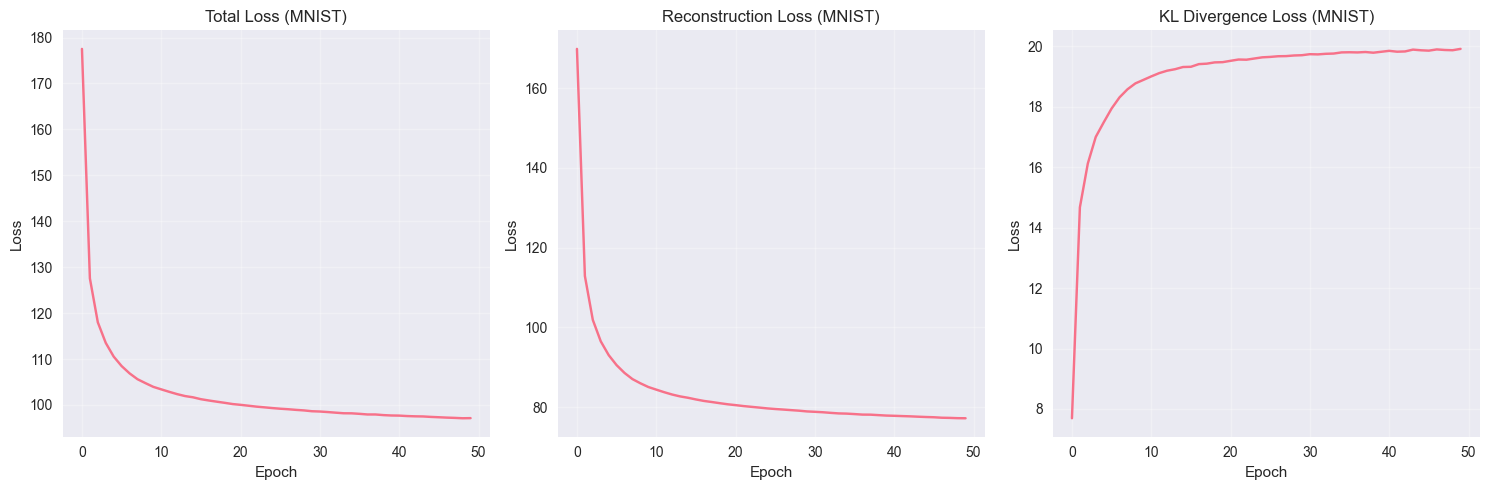

In [9]:
# Train VAE on MNIST digits
print("Training VAE on MNIST Digits...")
print("="*40)

mnist_vae = VAE(input_dim=784, latent_dim=20)
mnist_train_losses, mnist_recon_losses, mnist_kl_losses = train_vae(
    mnist_vae, mnist_train_loader, epochs=50, lr=1e-3, beta=1.0
)

print("✅ MNIST VAE training completed!")

# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(mnist_train_losses)
plt.title('Total Loss (MNIST)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(mnist_recon_losses)
plt.title('Reconstruction Loss (MNIST)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(mnist_kl_losses)
plt.title('KL Divergence Loss (MNIST)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()